# line racer tutorial

Welcome to the line racer tutorial! This notebook will outline the basic features of line racer, from how to calculate small line lists on your laptop to calculating the largest ones on clusters. Additionally, all available features for the line profile and the line calculation will be explained. Moreover, how to put out the opacities in the petitRADTRANS format, if desired. This notebook is also available here # todo: put the link there!

If you have not done yet, please have a look at the [guideline on how to install line racer](../installation.rst) and the [tutorial on how to download line lists](../downloading_line_list_data.rst). However, in this notebook, we will also download the line lists needed for the examples.

Additionally, if you are interested in the details and physics behind the line calculation and opacities in general, please look at the [explanation of the physics behind line racer](explain_line_calculation.ipynb). Here you also get guidelines on which cutoff to use, how the line broadening works, and if a sub-Lorentzian treatment is a good choice for your case.

To start with the opacity calculation, we need to install wget (if you haven't done yet, here done with brew), load the relevant packages: `numpy`, `line_racer` and check if line racer is installed correctly.

In [7]:
! brew install wget

To reinstall 1.25.0, run:
  brew reinstall wget


In [1]:
import numpy as np
import line_racer.line_racer as lr

lr.LineRacer.check_installation()

Running line racer installation test...
line racer installation test passed successfully.


The following part of this tutorial will be divided into the different databases. Opacity calculations with line lists from ExoMol will be explained in most detail and then the differences for HITRAN and HITEMP line lists will be outlined.

<div class="alert alert-warning">

Line racer requires to download line intensity correction data once before the first opacity calculation. This is done automatically when you prepare the opacity calculation for the first time. However, if that does not work, please download it manually from this [link](https://keeper.mpdl.mpg.de/d/cb4d751acf1941aab44b/) and store the files in a folder `data/`.
</div>

## Using ExoMol line lists

We need to download all of the required files, which is also explained in the [downloading line list data tutorial](../downloading_line_list_data.rst). Here, we will download the H2O line list POKAZATEL as an example. Since the line list is huge, we will only download a small part of it (one file) for demonstration purposes. In practice, you would download the whole line list, or at least the part that is relevant for you. First of all, we are creating the folder structure.

In [16]:
import os

os.makedirs('line_list/H2O', exist_ok=True)

After that, we are downloading the line list data. For ExoMol, always the `.states` file is needed and the `.trans` files of the required wavelength region. Since we do not want to use the default broadening parameters, we also need to download a `.broad` file. However, if you would want to use the default broadening parameters, you can look up the values in the [`.def`](https://www.exomol.com/data/molecules/H2O/1H2-16O/POKAZATEL/?export=def) file on ExoMol's website.
Finally, the `.pf` partition function file is required as well.

In [17]:
%cd line_list/H2O/

! wget https://www.exomol.com/db/H2O/1H2-16O/POKAZATEL/1H2-16O__POKAZATEL.states.bz2

! wget https://www.exomol.com/db/H2O/1H2-16O/POKAZATEL/1H2-16O__POKAZATEL__10000-10100.trans.bz2

! wget https://www.exomol.com/db/H2O/1H2-16O/1H2-16O__H2.broad
! wget https://www.exomol.com/db/H2O/1H2-16O/1H2-16O__He.broad

! wget https://www.exomol.com/db/H2O/1H2-16O/POKAZATEL/1H2-16O__POKAZATEL.pf

%cd ../..

/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/line_list/H2O
--2025-12-08 15:42:22--  https://www.exomol.com/db/H2O/1H2-16O/POKAZATEL/1H2-16O__POKAZATEL.states.bz2
Resolving www.exomol.com (www.exomol.com)... 128.40.3.60
Connecting to www.exomol.com (www.exomol.com)|128.40.3.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10209379 (9.7M) [application/x-bzip2]
Saving to: ‘1H2-16O__POKAZATEL.states.bz2’

1H2-16O__POKAZATEL. 100%[===================>]   9.74M  4.09MB/s    in 2.4s    

2025-12-08 15:42:24 (4.09 MB/s) - ‘1H2-16O__POKAZATEL.states.bz2’ saved [10209379/10209379]

--2025-12-08 15:42:25--  https://www.exomol.com/db/H2O/1H2-16O/POKAZATEL/1H2-16O__POKAZATEL__10000-10100.trans.bz2
Resolving www.exomol.com (www.exomol.com)... 128.40.3.60
Connecting to www.exomol.com (www.exomol.com)|128.40.3.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208438510 (199M) [application/x-bzip2]
Saving to: ‘1H2-16O__POKAZATEL

The last step before setting up the calculation is to choose the pressure and temperature grid. If you want to calculate your opacities for usage in petitRADTRANS, you can use their standard grid. It is stored in line racer. However, you can also define your own grid. The following command shows you how to use the pRT grid, but after that we are only using one pressure and temperature for demonstration purposes.


In [2]:
pressures, temperatures = lr.LineRacer.prt_pressure_temperature_grid()
print("petitRADTRANS pressure grid (in bar): ", pressures)
print("petitRADTRANS temperature grid (in K): ", temperatures)

pressures = [1e-3]  # in bar
temperatures = [500.0]  # in K

petitRADTRANS pressure grid (in bar):  [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
petitRADTRANS temperature grid (in K):  [  81.14113605  109.60677358  148.0586223   200.          270.16327371
  364.9409723   492.96823893  665.90956631  899.52154213 1215.08842295
 1641.36133093 2000.         2217.17775249 2500.         2750.
 2995.         3250.         3500.         3750.         4000.        ]


After that, we can define the line racer object, which already contains most of the relevant information for our opacity calculation. In general, everything is written in lower case letters, except for the line list name, since it is only used for naming the output files.

In [3]:
H2O_racer = lr.LineRacer(resolution=1e6,
                         cutoff=100.0,  # in 1/cm
                         lambda_min=1.1e-5,  # in cm
                         lambda_max=2.5e-2,  # in cm
                         grid_type='log',
                         hartmann=True,
                         database='exomol',
                         input_folder='line_list/H2O/',  # path to folder with input files
                         temperatures=temperatures,  # in K
                         pressures=pressures,  # in bar
                         mass=18.010565, # in amu
                         species_isotope_dict={'1H2-16O': 1.0},
                         line_list_name='POKAZATEL',
                         broadening_species_dict={'H2': 0.85, 'He': 0.15},
                         broadening_type='exomol_table',  # could also be 'sharp_burrows', 'hitran_table' or 'constant'
                         
                         # constant_broadening=[0.07, 0.5],  # if you want to use the default ExoMol broadening parameters, set this and change broadening_type to 'constant'
                        
                         # Change the following only if you know what you do!
                         force_molliere2015_method=False  # whether to force using Mollière et al. (2015) for line profile calculation, recommended only if warning appears or for small line lists
                         )

Calculating the opacity for the following species: ['1H2-16O']


The parameters we defined here are the following: The resolution of the wavelength grid we want to calculate the opacities on in the format of $\frac{\lambda}{\Delta\lambda}$, the cutoff of the line wings in 1/cm (100/cm is a good choice if the Hartmann et al. 2002 treatment is used), the minimum and maximum wavelength in cm (here the full pRT grid), the grid type (currently just logarithmic possible), whether to use the Hartmann et al. (2002) line wing corrections, the database we want to use (here ExoMol), the input folder where the line list files (`.states`, `.trans`, `.broad`, `.pf`) are stored, the temperature grid in Kelvin, the pressure grid in Bar, the molecular mass in amu (can be found in the [`.def`](https://www.exomol.com/data/molecules/H2O/1H2-16O/POKAZATEL/?export=def) file on ExoMol's website), a dictionary with isotopes we want to consider in the ExoMol naming convention and their abundances, the line list name (here POKAZATEL), a dictionary with the broadening species (as named at the end of the `.broad` file) and their abundances and finally the broadening type (here we use the ExoMol table values).

If you choose to use the default ExoMol broadening parameters, you can set `constant_broadening` to a list with the two values `[gamma [1/cm/bar], n_temp [dimensionless]]`, e.g. `[0.07, 0.5]` for the POKAZATEL line list. Additionally, you have to set `broadening_type = 'constant'`. In that case, you do not need to download the `.broad` files. The constant broadening parameters can also be found in the [`.def`](https://www.exomol.com/data/molecules/H2O/1H2-16O/POKAZATEL/?export=def) file on ExoMol's website

Additionally, there is one parameter: `force_molliere2015_method`, which forces the usage of the Mollière et al. (2015) method for line profile calculation. This is only recommended for small line lists or if you get warnings that the default method fails. It increases the calculation time significantly for large line lists. More about this method can be found in the [background information](explain_line_calculation.ipynb) of the line calculation.

After defining the racer object, we can start the opacity calculation. The first step is to prepare the opacity calculation. Here, the wavelength grid is set up and the intensity corrections of the lines to take the cutoff into account are prepared.
If you do that for the first time, line racer will download the files needed. More about that in the chapter to [intensity correction](#intensity-correction). As the most important step, the transition files list is either created by the function, or you can directly input it. If you do not provide it, line racer will search for all transition files in the input folder. Here, we are providing the transition files list directly.

In [9]:
transition_files_list = H2O_racer.prepare_opacity_calculation()  # or H2O_racer.prepare_opacity_calculation(transition_files_list=[list, of, the, files])

print("The transition file(s) to be used for the calculation are: ", transition_files_list)

Using Hartmann and cutoff intensity correction grid
The transition files to be used for the calculation are:  ['line_list/H2O/1H2-16O__POKAZATEL__10000-10100.trans.bz2']


<div class="alert alert-warning">

Line racer can read in the compressed `.bz2` files directly, however, the read in takes twice the time compared to the uncompressed files. Therefore, it is recommended to decompress the files before the calculation if possible.
</div>

After preparing the calculation, we can start the actual opacity calculation. Here, we can also choose whether to use [MPI](https://mpi4py.readthedocs.io/en/stable/) for parallelization or not. If you are on a cluster and have MPI set up, you can set `use_mpi=True` to use it. Otherwise, just set it to `False` and line racer will use [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) for parallelization. In the case of normal multiprocessing (`use_mpi=False`) you can choose the number of cores by setting `n_cores` to the number of cores you want to use. 

<div class="alert alert-warning">

If you are using the `line_racer_obj.calculate_opacity` in a script make sure to put it in a `if __name__ == "__main__":` block to avoid problems with multiprocessing.
</div>

The opacity can directly be output in the petitRADTRANS format by setting `prt_format=True`. However, we will explain that later. Here, we are first calculating the cross-sections in line racer's own format, which is a [`zarr`](https://zarr.readthedocs.io/en/stable/) compressed with `zip`. To directly save it in the petitRADTRANS format, just use the same parameters we will explain below. Here, they are set to `None`. Additionally, we are using the flag `verbose=True`, to get more information about the line calculation. This should be set to `False` if you want to run the calculation with maximum speed. The most important information is already printed without verbose mode.

In [7]:
final_cross_section_file_name = H2O_racer.calculate_opacity(transition_files_list, use_mpi=False, n_cores=1, sampling_boost=1.0, coarse_grid_switch=True, prt_format=False, doi=None, additional_information=None, verbose=True)

print("The cross-sections are stored in the file: ", final_cross_section_file_name)

Reading ExoMol states file...
Finished reading ExoMol states file in 3.17 seconds.
Reading ExoMol transition file...
Finished reading ExoMol transition file in 26.73 seconds.
Using ExoMol broadening table
Found a0 diet for perturber H2.
Found a0 diet for perturber He.
Line parameter calculation time: 0.940424919128418 s
Starting the line profile calculation of 23263918 lines
Calculating strong lines with Mollière et al. (2015) method
 Internal lines done!
 Starting external lines!
Progress: 770/773 subgrids
 External lines done!
Time strong lines: 4.605422019958496 s
Calculating weak lines with sampling method
Progress: 99/99 line packs (each containing 234782 lines)
 Calculating last pack (containing,           67  lines)!
Time for weak lines 5.712813138961792 s

Line profile calculation done
Total time for opacity calculation:  50.324743032455444 s

The cross-sections are stored in the file:  cross-sections/cross-section_1H2-16O__POKAZATEL__40-90909cm-1.zarr.zip


The resulting cross-section file is stored in the folder `cross-sections/` by default. The file contains the pressure grid in bar and temperature grid in Kelvin, the wavenumber grid in 1/cm and the cross-sections in $\text{cm^2/molecule}$ for each pressure and temperature point. If you want to convert the cross-sections to the petitRADTRANS format, you could directly set `prt_format=True` in the `calculate_opacity` function. 

The other additional options for the upper function are the `sampling_boost`, which can be used to increase the number of samples used to sample the weak lines. This increases the accuracy of the opacity calculation, but also the calculation time. The number of samples per line is already set to a good value by default, so changing this is usually not necessary. The last parameter is `coarse_grid_switch`, which controls whether to use an adaptive grid, which fits to the average width of the lines, so that only a required number of wavelength points are used to resolve the lines. This usually speeds up the calculation significantly. It is strongly recommended to keep it on, since there is no information lost. This feature was adapted from [de Regt et al. 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv251020870D/abstract).

After calculating the opacities, we can plot them. Since we only used one pressure temperature point, we will just plot that one here. The line racer internal file format is a `zarr` compressed with `zip`, which can be read in easily with the `zarr` package.

In [12]:
import zarr.storage

# Open read-only ZipStore
store = zarr.storage.ZipStore(final_cross_section_file_name, mode='a')
z = zarr.group(store=store)

# Access datasets
pressures = z['pressures'][:]
temperatures = z['temperatures'][:]
wavenumbers = z['wavenumbers'][:]
cross_section = z['cross-sections']

print("Pressures (Bar): ", pressures)
print("Temperatures (K): ", temperatures)

# Extract slice and plot
cross_section_slice = cross_section[:]

Pressures (bar):  [0.001]
Temperatures (K):  [500.]


The cross-sections are stored in a 3D array with the shape (n_pressures, n_temperatures, n_wavenumbers). Here, we only have one pressure and temperature point, so we can just extract the first slice of the array. After that, we can plot the cross-sections.

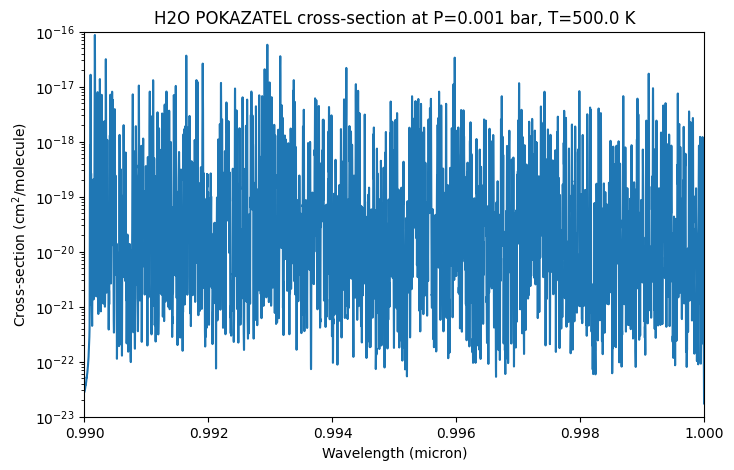

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(1/wavenumbers[::-1] * 1e4, cross_section_slice[0, 0, ::-1])  # convert wavenumber to wavelength in micron
ax.set_xlabel('Wavelength (micron)')
ax.set_ylabel('Cross-section (cm$^2$/molecule)')
ax.set_title(f'H2O POKAZATEL cross-section at P={pressures[0]} bar, T={temperatures[0]} K')
ax.set_yscale('log')
ax.set_xlim(0.99, 1.0)
ax.set_ylim(1e-23, 1e-16);

If you want to convert the file to the pRT format afterwards, you can use the following function. For that you need to have a working petitRADTRANS installation. A guide on how to install petitRADTRANS can be found [here](https://petitradtrans.readthedocs.io/en/latest/content/installation.html).
Before using it, you need to set the input data path of petitRADTRANS to the folder where you want to store the converted file. Probably you have already done that if have been using petitRADTRANS, but if not, here is how to do it:

In [27]:
from petitRADTRANS.config import petitradtrans_config_parser

input_dir= 'petitradtrans_data/'

# make sure the input data path exists
os.makedirs(input_dir+'input_data', exist_ok=True)

petitradtrans_config_parser.set_input_data_path(input_dir+'input_data')

Input data path changed to '/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/petitradtrans_data/input_data'


If you use the pRT format, please provide the DOI of the line list you used for the calculation, so that it is stored in the file. Additionally, you can provide information you want to include into the file. 
The standard information includes the isotope list, the line racer version, the line list name, the broadening species dictionary, the broadening type, the cutoff and weather Hartmann corrections were used.

The `rewrite` parameter controls whether to overwrite an already existing file with the same name. If you want to keep the old file if one exists, set it to `False`.

In [28]:
add_info = "this was a test calculation of H2O opacities using line racer."
doi = "10.1093/mnras/sty1877"  # doi of the line list

H2O_racer.convert_opacity_to_prt_format(final_cross_section_file_name, doi, rewrite=True, additional_information=add_info)

Generating petitRADTRANS wavenumber grid... Done.
Reading opacity files in directory '.temporary_pRT_xsec'...
Starting conversion of directory '.temporary_pRT_xsec'...
 Reading file '.temporary_pRT_xsec/xsec_1H2-16O_1.00e-03bar_500K.zarr' (1/1)... Done.
Preparation successful
Starting line-by-line conversion (boundaries: [ 0.3 28. ])...
Creating directory '/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/petitradtrans_data/input_data/opacities/lines/line_by_line/H2O/1H2-16O'
 Writing line-by-line file '/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/petitradtrans_data/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__POKAZATEL.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'...
Successfully converted files in '.temporary_pRT_xsec' to line-by-line pRT files
Starting correlated-k conversion (R = 1000)...
 Reshaping...
 Initializing correlated-k parameters...


/Users/haegele/anaconda3/envs/line_opa_code_env_py311/lib/python3.11/site-packages/petitRADTRANS/__file_conversion.py:3135: UserWarning: directory '.temporary_pRT_xsec' contains only 1 files, the standard petitRADTRANS temperature-pressure grid size is 130; a finer temperature-pressure grid allows for a more accurate interpolation of the cross-sections
  warnings.warn(f"directory '{opacities_directory}' contains only {len(opacity_files)} files, "


 Done.lating correlated-k (7728/7728)...
Creating directory '/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/petitradtrans_data/input_data/opacities/lines/correlated_k/H2O/1H2-16O'
 Writing file '/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/petitradtrans_data/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.1-250mu.ktable.petitRADTRANS.h5'...
Successfully converted files in '.temporary_pRT_xsec' to correlated-k pRT files
Removed temporary folder .temporary_pRT_xsec with the individual p T point files.


We can ignore the warning about the number of files, since we only used one file for demonstration purposes. In practice, you would use the whole line list or at least all files covering the wavelength region of interest. The resulting file can be directly used in petitRADTRANS.

## Using HITRAN line lists

A guide on how to download HITRAN line lists can be found in the downloading line list data [tutorial](../downloading_line_list_data.rst). To download HITRAN data, you need to be logged in on the HITRAN website. Therefore, we will download the demonstration data from a cloud, just to show how the calculation works. If you want to use the HITRAN data for real, please download the line list files from the HITRAN website. 

We will calculate the HITRAN CO2 line list here. Credit for the data goes to these [papers](https://keeper.mpdl.mpg.de/f/efc3f6da710c443e9d9e/). First we need to set up the folder structure.

In [34]:
import os
import urllib.request

os.makedirs('line_list/CO2', exist_ok=True)

After that, we are downloading the line list data. As mentioned, it is downloaded from a cloud using `urllib.request`. If that is not working for you, please download it manually from HITRAN or [here](https://keeper.mpdl.mpg.de/d/61b649a333964c3ebe1d/). However, the partition function can be downloaded from the HITRAN website directly. For HITRAN data the `.par` file is needed, which contains all line information. Additionally, the partition function data is needed, which is stored in a `.txt` file.

In [41]:
urllib.request.urlretrieve('https://keeper.mpdl.mpg.de/f/3b4ddd913b7e44e984fe/?dl=1', 'line_list/CO2/69300f3e.par')

%cd line_list/CO2/
! wget https://hitran.org/data/Q/q7.txt
%cd ../..

/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/line_list/CO2
--2025-12-08 17:10:55--  https://hitran.org/data/Q/q7.txt
Resolving hitran.org (hitran.org)... 131.142.195.62
Connecting to hitran.org (hitran.org)|131.142.195.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129998 (127K) [text/plain]
Saving to: ‘q7.txt.2’

q7.txt.2            100%[===================>] 126.95K   470KB/s    in 0.3s    

2025-12-08 17:10:55 (470 KB/s) - ‘q7.txt.2’ saved [129998/129998]

/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks


As for ExoMol, we need to define the pressure and temperature grid. Here, we are only using one pressure and temperature point for demonstration purposes. If you want to use a pre-defined petitRADTRANS grid, you can use the function `lr.LineRacer.prt_pressure_temperature_grid()` as shown in the ExoMol example.

In [42]:
pressures = [1.0]  # in bar
temperatures = [1500.0]  # in K

After that, we can define the line racer object, which already contains most of the relevant information for our opacity calculation. In general, everything is written in lower case letters, except for the line list name, since it is only used for naming the output files.

In [43]:
CO2_racer = lr.LineRacer(resolution=1e6,
                         cutoff=100.0,  # in 1/cm
                         lambda_min=1.1e-5,  # in cm
                         lambda_max=2.5e-2,  # in cm
                         grid_type='log',
                         hartmann=True,
                         database='hitran',
                         input_folder='line_list/CO2/',  # path to folder with input files
                         temperatures=temperatures,  # in K
                         pressures=pressures,  # in bar
                         species_isotope_dict={'12C-16O2': 1.0},
                         line_list_name='HITRAN2024',
                         broadening_species_dict={'air': 1.0},
                         broadening_type='hitran_table',  # could also be 'sharp_burrows', 'hitran_table' or 'constant'
                        
                         # Change the following only if you know what you do!
                         force_molliere2015_method=False  # whether to force using Mollière et al. (2015) for line profile calculation, recommended only if warning appears or for small line lists
                         )

Calculating the opacity for the following species: ['12C-16O2']


A detailed description of the class can be found in the ExoMol section. Here, we will just explain the differences. 

The input folder where the line list files (`.par/.out`, `.txt`) are stored is now the one containing the HITRAN files, the naming convention of the dictionary with the isotopes to calculate is still in the ExoMol naming convention and will be translated internally. Since the HITRAN line lists do not have specific names, we just call it 'hitran'. For the dictionary with the broadening species `air` and `self` is possible for `.par` files. For self created `.out` files the species names as seen on the HITRAN website in the output format description are required as an input here. The broadening type is a and their abundances and finally the broadening type HITRAN table. The molecular mass is not required for HITRAN line lists, since it is read from the `molparam.txt` file automatically.

The explanation for `force_molliere2015_method` can be found in the ExoMol section.

We also need to prepare the calculation by setting up the wavelength grid and prepare the intensity correction. Additionally, to the intensity correction files, for HITRAN line lists, the `molparam.txt` file is needed, which is downloaded automatically if not present in the `data/` folder. More about the intensity correction can be found in the ExoMol section and the [intensity correction](#intensity-correction) chapter.

Finally, we can provide the transition files list directly here, or let line racer search for all `.par` or `.out` files in the input folder. If there are `.par` and `.out` files, the `.out` files are preferred.

In [44]:
transition_files_list = CO2_racer.prepare_opacity_calculation()
print("The transition file(s) to be used for the calculation are: ", transition_files_list)

Using Hartmann and cutoff intensity correction grid
The transition file(s) to be used for the calculation are:  ['line_list/CO2/69300f3e.par']


After preparing the calculation, we can start the actual opacity calculation. Here, we can also choose whether to use [MPI](https://mpi4py.readthedocs.io/en/stable/) for parallelization or not. If you are on a cluster and have MPI set up, you can set `use_mpi=True` to use it. Otherwise, just set it to `False` and line racer will use multiprocessing for parallelization. In the case of normal multiprocessing (`use_mpi=False`) you can choose the number of cores by setting `n_cores` to the number of cores you want to use.

<div class="alert alert-warning">

If you are using the `line_racer_obj.calculate_opacity` in a script make sure to put it in a `if __name__ == "__main__":` block to avoid problems with multiprocessing.
</div>

You can either directly use the petitRADTRANS format by setting `prt_format=True` or first calculate the cross-sections in line racer's own format, which is a [`zarr`](https://zarr.readthedocs.io/en/stable/) compressed with `zip`. More about that, and which further information are needed for the petitRADTRANS format can be found in the ExoMol section. Here, they are set to `None`. We use the flag `verbose=True`, to get more information about the line calculation.

In [59]:
final_cross_section_file_name = CO2_racer.calculate_opacity(transition_files_list, use_mpi=False, n_cores=1, prt_format=False, doi=None, additional_information=None, verbose=True)

print("The cross-sections are stored in the file: ", final_cross_section_file_name)

Reading HITRAN transition file...
Finished reading HITRAN transition file in 1.34 seconds.
Line parameter calculation time: 0.022244691848754883 s
Starting the line profile calculation of 174446 lines
 Starting internal lines!
 Internal lines done!
 Starting external lines!
Progress: 770/773 subgrids
 External lines done!
Line profile calculation done
Total time for opacity calculation:  60.2680230140686 s

The cross-sections are stored in the file:  cross-sections/cross-section_12C-16O2__HITRAN2024__40-90909cm-1.zarr.zip


The resulting cross-section file is stored in the folder `cross-sections/` by default. The file contains the pressure grid in Bar and temperature grid in Kelvin, the wavenumber grid in 1/cm and the cross-sections in $\text{cm^2/molecule}$ for each pressure and temperature point. If you want to convert the cross-sections to the petitRADTRANS format, you could directly set `prt_format=True` in the `calculate_opacity` function or just convert it afterward, as explained in the ExoMol section.

In [60]:
import zarr.storage

store = zarr.storage.ZipStore(final_cross_section_file_name, mode='a')
z = zarr.group(store=store)

# Access datasets
pressures = z['pressures'][:]
temperatures = z['temperatures'][:]
wavenumbers = z['wavenumbers'][:]
cross_section = z['cross-sections']

print("Pressures (bar): ", pressures)
print("Temperatures (K): ", temperatures)

# Extract slice and plot
cross_section_slice = cross_section[:]

Pressures (bar):  [1.]
Temperatures (K):  [1500.]


In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(1/wavenumbers[::-1] * 1e4, cross_section_slice[0, 0, ::-1])  # convert wavenumber to wavelength in micron

ax.set_xlabel('Wavelength (micron)')
ax.set_ylabel('Cross-section (cm$^2$/molecule)')
ax.set_title(f'CO2 HITRAN at P={pressures[0]} bar, T={temperatures[0]} K')
ax.set_yscale('log')
ax.set_ylim(1e-25, 1e-11)
ax.set_xlim(0.3, 10);

/var/folders/bv/dcps6_qx5qgcwbg6nt406g1h0000gn/T/ipykernel_77750/676692216.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


## Using HITEMP line lists

The resulting cross-section file is stored in the folder `cross-sections/` by default. The file contains the pressure grid in Bar and temperature grid in Kelvin, the wavenumber grid in 1/cm and the cross-sections in $\text{cm^2/molecule}$ for each pressure and temperature point. If you want to convert the cross-sections to the petitRADTRANS format, you could directly set `prt_format=True` in the `calculate_opacity` function or just convert it afterward, as explained in the ExoMol section.

A guide on how to download HITEMP line lists can be found in the downloading line list data [tutorial](../downloading_line_list_data.rst). To download HITEMP data, you need to be logged in on the HITRAN website. Therefore, we will download the demonstration data from a cloud, just to show how the calculation works. If you want to use the HITEMP data for real, please download the line list files from the HITRAN website. 

We will calculate the HITRAN CO line list here. Credit for the data goes to  [G. Li et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJS..216...15L/abstract). First we need to set up the folder structure.

In [76]:
import os

os.makedirs('line_list/CO', exist_ok=True)

After that, we are downloading the line list data. As mentioned, it is downloaded from a cloud using `urllib.request`. If that is not working for you, please download it manually from HITRAN or [here](https://keeper.mpdl.mpg.de/d/75eecbe3a6ef468aa55b/). However, the partition function can be downloaded from the HITRAN website directly. For HITRAN data the `.par` file is needed, which contains all line information. Additionally, the partition function data is needed, which is stored in a `.txt` file.

In [77]:
urllib.request.urlretrieve('https://keeper.mpdl.mpg.de/f/be281779a65542db814e/?dl=1', 'line_list/CO/05_HITEMP2019.par')

%cd line_list/CO/
! wget https://hitran.org/data/Q/q26.txt
%cd ../..

/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks/line_list/CO
--2025-12-08 17:31:56--  https://hitran.org/data/Q/q26.txt
Resolving hitran.org (hitran.org)... 131.142.195.62
Connecting to hitran.org (hitran.org)|131.142.195.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233998 (229K) [text/plain]
Saving to: ‘q26.txt.1’

q26.txt.1           100%[===================>] 228.51K   701KB/s    in 0.3s    

2025-12-08 17:31:57 (701 KB/s) - ‘q26.txt.1’ saved [233998/233998]

/Users/haegele/PycharmProjects/line_racer/docs/content/notebooks


As for ExoMol, we need to define the pressure and temperature grid. Here, we are only using one pressure and temperature point for demonstration purposes. If you want to use a pre-defined petitRADTRANS grid, you can use the function `lr.LineRacer.prt_pressure_temperature_grid()` as shown in the ExoMol example.

In [78]:
pressures = [1.0]  # in bar
temperatures = [1500.0]  # in K

After that, we can define the line racer object, which already contains most of the relevant information for our opacity calculation. In general, everything is written in lower case letters, except for the line list name, since it is only used for naming the output files.

In [80]:
CO_racer = lr.LineRacer(resolution=1e6,
                         cutoff=100.0,  # in 1/cm
                         lambda_min=1.1e-5,  # in cm
                         lambda_max=2.5e-2,  # in cm
                         grid_type='log',
                         hartmann=True,
                         database='hitemp', 
                         input_folder='line_list/CO/',  # path to folder with input files
                         temperatures=temperatures,  # in K
                         pressures=pressures,  # in bar
                         species_isotope_dict={'12C-16O': 1.0},
                         line_list_name='HITEMP2019',  # you can specify the version here
                         broadening_species_dict={'air': 1.0},
                         broadening_type='hitran_table',  # could also be 'sharp_burrows', 'hitran_table' or 'constant'
                        
                         # Change the following only if you know what you do!
                         force_molliere2015_method=False  # whether to force using Mollière et al. (2015) for line profile calculation, recommended only if warning appears or for small line lists
                         )

Calculating the opacity for the following species: ['12C-16O']


A detailed description of the class can be found in the ExoMol section. Here, we will just explain the differences. 

The input folder where the line list files (`.par/.out`, `.txt`) are stored is now the one containing the HITEMP files. The naming convention of the dictionary with the isotopes to calculate is still in the ExoMol naming convention and will be translated internally. Since the HITEMP line lists do not have specific names, we just call it 'HITEMP'. For the dictionary with the broadening species `air` and `self` is possible for `.par` files. The broadening type is `air` and the broadening type HITRAN table, since HITRAN is the provider of the HITEMP line lists. The molecular mass is not required for HITEMP line lists, since it is read from the `molparam.txt` file automatically.

The explanation for `force_molliere2015_method` can be found in the ExoMol section.

We also need to prepare the calculation by setting up the wavelength grid and prepare the intensity correction. Additionally, to the intensity correction files, for HITEMP line lists, the `molparam.txt` file is needed, which is downloaded automatically if not present in the `data/` folder. More about the intensity correction can be found in the ExoMol section and the [intensity correction](#intensity-correction) chapter.

Finally, we can provide the transition files list directly here, or let line racer search for all `.par` files in the input folder.

In [82]:
transition_files_list = CO_racer.prepare_opacity_calculation()

print("The transition file(s) to be used for the calculation are: ", transition_files_list)

Using Hartmann and cutoff intensity correction grid
The transition file(s) to be used for the calculation are:  ['line_list/CO/05_HITEMP2019.par']


After preparing the calculation, we can start the actual opacity calculation. Here, we can also choose whether to use [MPI](https://mpi4py.readthedocs.io/en/stable/) for parallelization or not. If you are on a cluster and have MPI set up, you can set `use_mpi=True` to use it. Otherwise, just set it to `False` and line racer will use multiprocessing for parallelization. In the case of normal multiprocessing (`use_mpi=False`) you can choose the number of cores by setting `n_cores` to the number of cores you want to use.

<div class="alert alert-warning">

If you are using the `line_racer_obj.calculate_opacity` in a script make sure to put it in a `if __name__ == "__main__":` block to avoid problems with multiprocessing.
</div>

You can either directly use the petitRADTRANS format by setting `prt_format=True` or first calculate the cross-sections in line racer's own format, which is a `zarr` compressed with `zip`. More about that, and which further information are needed for the petitRADTRANS format can be found in the ExoMol section. Here, they are set to `None`. We use the flag `verbose=True`, to get more information about the line calculation.

In [83]:
# calculate the final cross-sections
final_cross_section_file_name = CO_racer.calculate_opacity(transition_files_list, use_mpi=False, n_cores=1, prt_format=False, doi=None, additional_information=None, verbose=True)

print("The cross-sections are stored in the file: ", final_cross_section_file_name)

Reading HITRAN transition file...
Finished reading HITRAN transition file in 4.24 seconds.
Line parameter calculation time: 0.018213748931884766 s
Starting the line profile calculation of 125496 lines
 Starting internal lines!
 Internal lines done!
 Starting external lines!
Progress: 770/773 subgrids
 External lines done!
Line profile calculation done
Total time for opacity calculation:  73.30534291267395 s

The cross-sections are stored in the file:  cross-sections/cross-section_12C-16O__HITEMP2019__40-90909cm-1.zarr.zip


The resulting cross-section file is stored in the folder `cross-sections/` by default. The file contains the pressure grid in Bar and temperature grid in Kelvin, the wavenumber grid in 1/cm and the cross-sections in $\text{cm^2/molecule}$ for each pressure and temperature point. If you want to convert the cross-sections to the petitRADTRANS format, you could directly set `prt_format=True` in the `calculate_opacity` function or just convert it afterward, as explained in the ExoMol section.

In [84]:
import zarr.storage

store = zarr.storage.ZipStore(final_cross_section_file_name, mode='a')
z = zarr.group(store=store)

# Access datasets
pressures = z['pressures'][:]
temperatures = z['temperatures'][:]
wavenumbers = z['wavenumbers'][:]
cross_section = z['cross-sections']

print("Pressures (bar): ", pressures)
print("Temperatures (K): ", temperatures)

# Extract slice and plot
cross_section_slice = cross_section[:]

Pressures (bar):  [1.]
Temperatures (K):  [1500.]


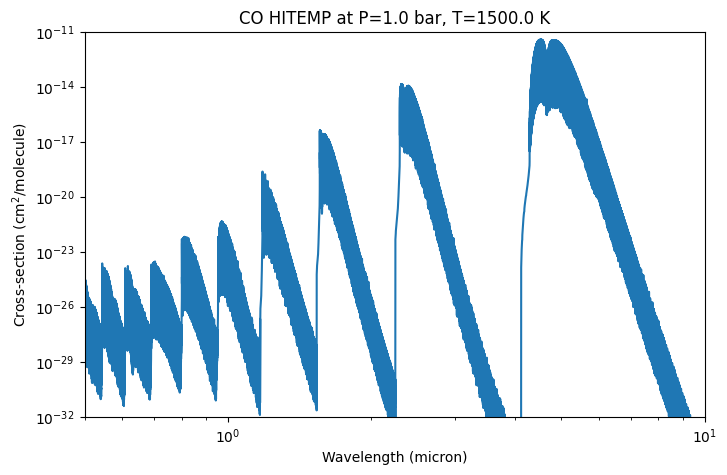

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(1/wavenumbers[::-1] * 1e4, cross_section_slice[0, 0, ::-1])  # convert wavenumber to wavelength in micron

ax.set_xlabel('Wavelength (micron)')
ax.set_ylabel('Cross-section (cm$^2$/molecule)')
ax.set_title(f'CO HITEMP at P={pressures[0]} bar, T={temperatures[0]} K')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-32, 1e-11)
ax.set_xlim(0.5, 10);

# Intensity Correction 

Because of the cutoff or sub-Lorentzian treatment of the line wings, the total line intensity is not conserved anymore. To account for that, line racer uses pre-calculated intensity correction grids. These are downloaded by default when you prepare the opacity calculation for the first time. However, if that does not work, you can download them manually from this [link](https://keeper.mpdl.mpg.de/d/cb4d751acf1941aab44b/) and store the files in a folder `data/`.
The pre-calculated grid ranges from Gaussian widths of 1e-5 to 1e2 1/cm, gamma/sigma ratios from 1e-9 to 1e6 and cutoff values from 1 to 5000 1/cm. The grid has 500 points in the width direction and 100 points in the gamma/sigma ratio and cutoff direction. The intensity correction is calculated for two cases: with Hartmann et al. (2002) corrections and cutoff only. Depending on whether you use the Hartmann corrections or not, the respective grid is used for the intensity correction. If your cutoff is larger than 5000 1/cm, no intensity correction is applied. If the line widths are outside of the grid, the nearest value is used.

You can also calculate the grids manually by running the following code, for example if you want to use a larger cutoff or range of line widths. The grids are stored in the `data/` folder. More about the intensity correction and how it works can be found in the [background information](explain_line_calculation.ipynb) of the line calculation.



In [2]:
import os
from line_racer.intensity_correction_precalculation import calculate_correction_grid

# Define parameters for the correction grid calculation
gamma_sigma_ratio_minimum = 1e-9
gamma_sigma_ratio_maximum = 1e6
sigma_minimum = 1e-5
sigma_maximum = 1e2
width_points = 50  # normally 500!!!
cutoff_minimum = 1
cutoff_maximum = 5000
cutoff_points = 1  # normally 100!!!

os.makedirs("dataa/", exist_ok=True)

# calculate the grid for the Hartmann and cutoff correction
Hartmann = True
hartmann_cutoff_correction_grid, sigma_grid, gamma_sigma_ratio_grid, cutoff_grid = calculate_correction_grid(
                                                                            gamma_sigma_ratio_minimum,
                                                                            gamma_sigma_ratio_maximum,
                                                                            sigma_minimum, sigma_maximum, width_points,
                                                                            cutoff_minimum, cutoff_maximum,
                                                                            cutoff_points, Hartmann)
np.savez('dataa/correction_grid_Hartmann_cutoff.npz', sigma_grid=sigma_grid, gamma_sigma_ratio_grid=gamma_sigma_ratio_grid,
         cutoff_grid=cutoff_grid, correction_grid=hartmann_cutoff_correction_grid)

# calculate the grid for the cutoff correction only
Hartmann = False
cutoff_correction_grid, sigma_grid, gamma_sigma_ratio_grid, cutoff_grid = calculate_correction_grid(
                                                                            gamma_sigma_ratio_minimum,
                                                                            gamma_sigma_ratio_maximum,
                                                                            sigma_minimum, sigma_maximum, width_points,
                                                                            cutoff_minimum, cutoff_maximum,
                                                                            cutoff_points, Hartmann)
np.savez('dataa/correction_grid_cutoff.npz', sigma_grid=sigma_grid, gamma_sigma_ratio_grid=gamma_sigma_ratio_grid,
         cutoff_grid=cutoff_grid, correction_grid=cutoff_correction_grid)

import shutil
shutil.rmtree("dataa/")

Calculating correction grid for cutoff  and using Hartmann correction 1.00 cm^-1 (1/1)
Calculating correction grid for cutoff  1.00 cm^-1 (1/1)


For calculation time reasons, we are just using one cutoff value and 50 width values here for the grid and also create a folder `dataa/` instead of `data/`. In practice, you would want to use 100 cutoff points and store the files in the `data/` folder.